# CycleGAN



</br></br>
### Import Data and Libraries
---

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
!unzip horse2zebra.zip

--2024-12-20 20:13:39--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M   830KB/s    in 3m 45s  

2024-12-20 20:17:25 (507 KB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]

Archive:  horse2zebra.zip
   creating: horse2zebra/
   creating: horse2zebra/trainA/
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/trainA/

In [ ]:
def get_image_tensor(dir):
  images = []
  for img_name in os.listdir(dir):
    img = cv2.imread(f"{dir}/{img_name}")
    D1, D2, D3 = img.shape
    images.append(torch.tensor(img).view(1, D1, D2, D3))

  return torch.cat(images)

In [ ]:
train_A = get_image_tensor("horse2zebra/trainA")
train_B = get_image_tensor("horse2zebra/trainB")
test_A  = get_image_tensor("horse2zebra/testA")
test_B  = get_image_tensor("horse2zebra/testB")

In [ ]:
EPOCHS        = 10
LEARNING_RATE = 3e-4
LAMBDA        = 5
BATCH_SIZE    = 32
DEVICE        = 'cuda' if torch.cuda.is_available() else 'cpu'

</br></br>

### EDA
---

In [ ]:
train_A.shape, train_B.shape, test_A.shape, test_B.shape

(torch.Size([1067, 256, 256, 3]),
 torch.Size([1334, 256, 256, 3]),
 torch.Size([120, 256, 256, 3]),
 torch.Size([140, 256, 256, 3]))

In [ ]:
def plot_data(dataset):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    idx = torch.randint(0, dataset.shape[0], (1,))
    plt.subplot(5, 5, i + 1)
    plt.imshow(dataset[idx.item()])
    plt.xticks([])
    plt.yticks([])

  plt.tight_layout()

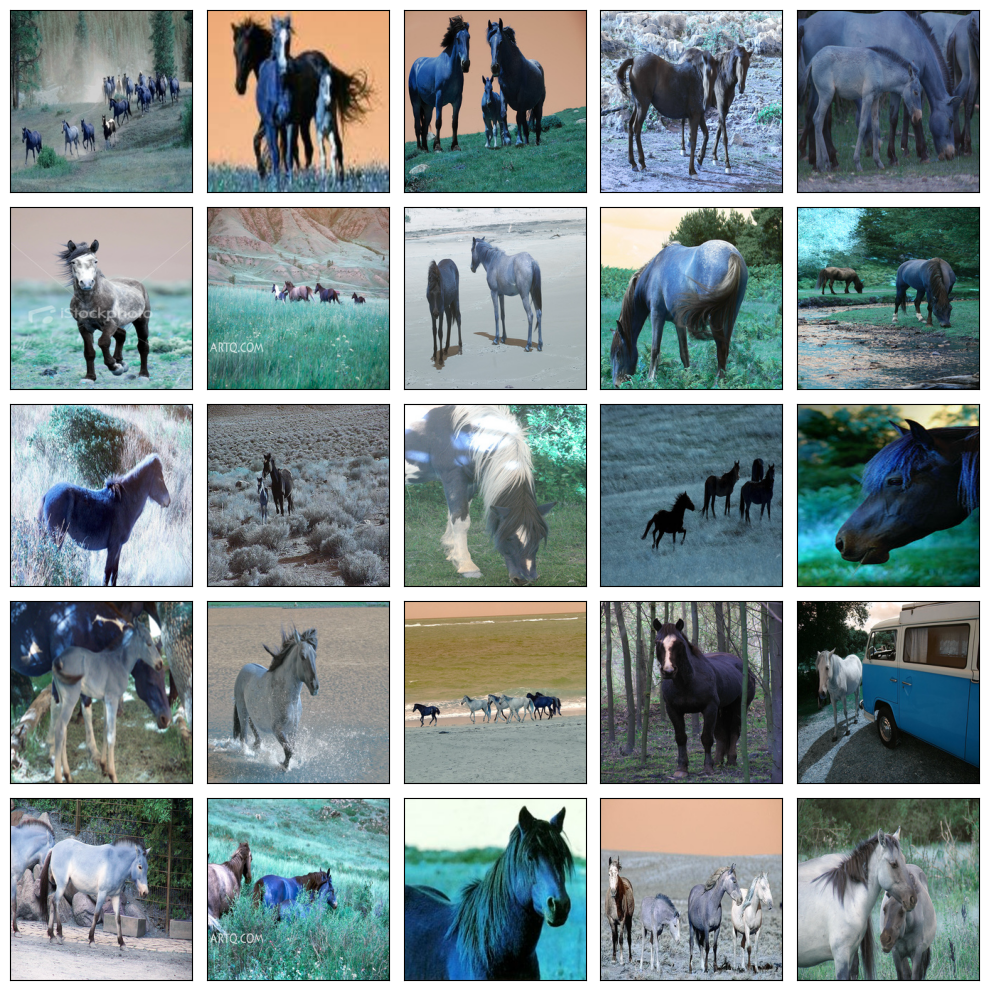

In [ ]:
plot_data(train_A)

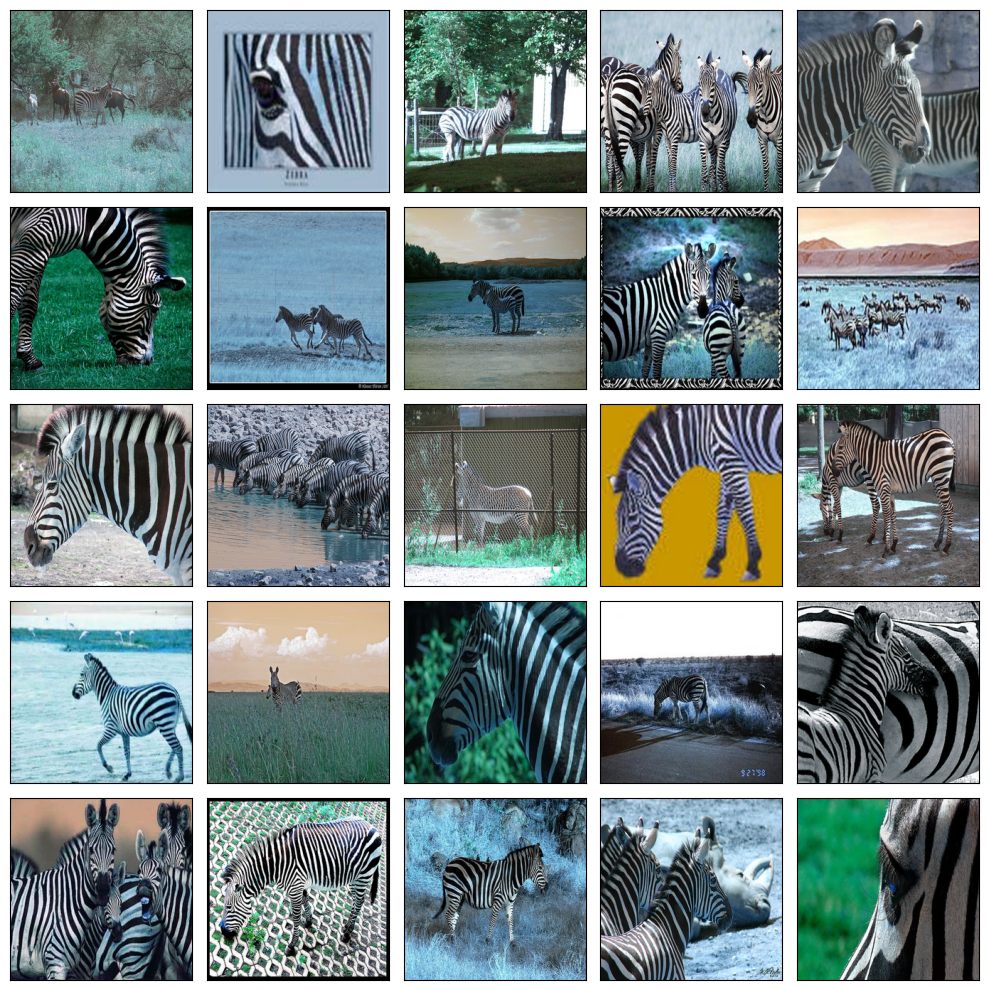

In [ ]:
plot_data(train_B)

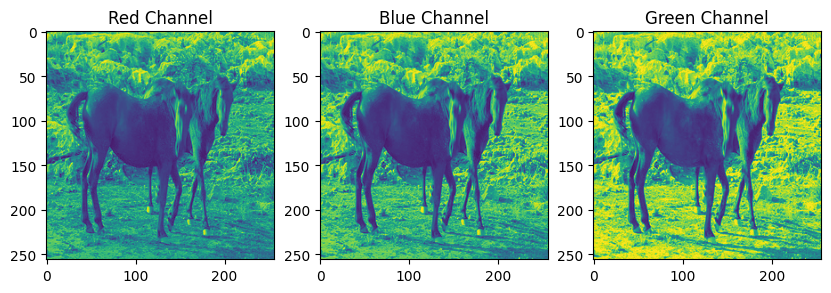

In [ ]:
def plot_channels(img):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 3, 1)
  plt.title("Red Channel")
  plt.imshow(img[:,:,0])

  plt.subplot(1, 3, 2)
  plt.title("Blue Channel")
  plt.imshow(img[:,:,1])

  plt.subplot(1, 3, 3)
  plt.title("Green Channel")
  plt.imshow(img[:,:,2])


plot_channels(train_A[0])

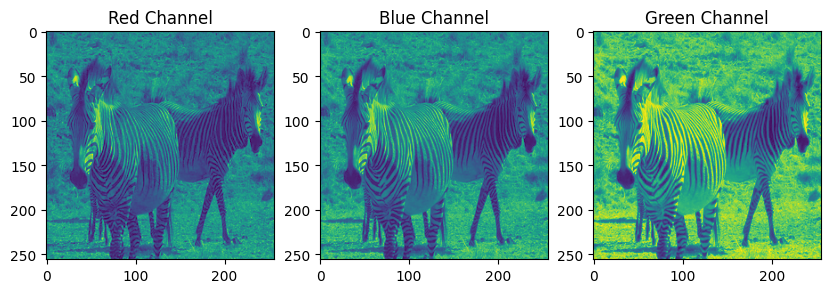

In [ ]:
plot_channels(train_B[0])

</br></br>

### Create Dataset
---

In [ ]:
train_len = train_A.shape[0] - (train_A.shape[0] % BATCH_SIZE)
test_len  = test_A.shape[0] - (test_A.shape[0] % BATCH_SIZE)

train_A = train_A[:train_len]
train_B = train_B[:train_len]
test_A  = test_A[:test_len]
test_B  = test_B[:test_len]

In [ ]:
class CycleGanData(Dataset):
  def __init__(self, A, B):
    self.A = A.to(DEVICE)
    self.B = B.to(DEVICE)

  def __len__(self):
    return self.A.shape[0]

  def __getitem__(self, idx):
    return (self.A[idx], self.B[idx])

In [ ]:
train_data = DataLoader(CycleGanData(train_A, train_B), shuffle=True, batch_size=BATCH_SIZE)
test_data  = DataLoader(CycleGanData(test_A, test_B),   shuffle=True, batch_size=BATCH_SIZE)

</br></br>

### Create Model Architecture
---

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, 16, 3)
    self.norm1 = nn.InstanceNorm2d(16)
    self.pool1 = nn.MaxPool2d(2)

    self.conv2 = nn.Conv2d(16, 32, 3)
    self.norm2 = nn.InstanceNorm2d(32)
    self.pool2 = nn.MaxPool2d(2)

    self.conv3 = nn.Conv2d(32, 64, 3)
    self.norm3 = nn.InstanceNorm2d(64)
    self.pool3 = nn.MaxPool2d(2)

    self.upconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, dilation=2)
    self.upconv2 = nn.ConvTranspose2d(32, 16, 3,  stride=2)
    self.upconv3 = nn.ConvTranspose2d(16, 3, 4,   stride=2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.pool1(x)
    x = F.relu(x, inplace=False)

    x = self.conv2(x)
    x = self.norm2(x)
    x = self.pool2(x)
    x = F.relu(x, inplace=False)

    x = self.conv3(x)
    x = self.norm3(x)
    x = self.pool3(x)
    x = F.relu(x, inplace=False)

    x = self.upconv1(x)
    x = self.upconv2(x)
    x = self.upconv3(x)
    x = F.tanh(x)

    return x


class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 1, 3)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(1, 1, 3)
    self.pool2 = nn.MaxPool2d(2)
    self.ff1   = nn.Linear(3844, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = F.relu(x, inplace=False)

    x = self.conv2(x)
    x = self.pool2(x)
    x = F.relu(x, inplace=False)

    x = x.view((x.shape[0], -1))

    x = self.ff1(x)
    x = F.sigmoid(x)

    return x

In [ ]:
G_gen = Generator(3).to(DEVICE)
F_gen = Generator(3).to(DEVICE)

Dx = Discriminator().to(DEVICE)
Dy = Discriminator().to(DEVICE)

optim_G  = torch.optim.AdamW(G_gen.parameters(), lr=LEARNING_RATE)
optim_F  = torch.optim.AdamW(F_gen.parameters(), lr=LEARNING_RATE)
optim_Dx = torch.optim.AdamW(Dx.parameters(),    lr=LEARNING_RATE)
optim_Dy = torch.optim.AdamW(Dy.parameters(),    lr=LEARNING_RATE)

In [ ]:
def disc_loss(Disc, G_out, reals):
  fake_out    = Disc(G_out.detach())
  fake_labels = torch.zeros((G_out.shape[0], 1)).to(DEVICE)
  fake_loss   = F.binary_cross_entropy(fake_out, fake_labels)

  real_out    = Disc(reals)
  real_labels = torch.ones((reals.shape[0], 1)).to(DEVICE)
  real_loss   = F.binary_cross_entropy(real_out, real_labels)

  loss = (real_loss + fake_loss) / 2
  return loss


def gen_loss(G_out, Disc):
  fake_out  = Disc(G_out)
  labels    = torch.ones((fake_out.shape[0], 1)).to(DEVICE)
  loss      = F.binary_cross_entropy(fake_out, labels)

  return loss


def adversarial_loss(G_out, Disc, a_batch, b_batch):
  g_loss = gen_loss(Gen,  Disc, G_out, reals)
  d_loss = disc_loss(Gen, Disc, input, reals)

  return (d_loss, g_loss)


def cycle_loss(F_g_out, G_F_out, a_batch, b_batch):
  forward_loss  = F.l1_loss(F_g_out, a_batch)
  backward_loss = F.l1_loss(G_F_out, b_batch)

  return (forward_loss, backward_loss)


def step(loss, optim):
  print("--- optim start ---")
  optim.zero_grad()
  loss.backward()
  optim.step()
  print("--- optim end ---\n\n\n")

In [ ]:
def train_epoch(models, data, optims, lam):
  G_gen, F_gen, Dx, Dy = models
  a_batch, b_batch = data
  optim_G, optim_F, optim_Dx, optim_Dy = optims

  G_out = G_gen(a_batch)
  F_out = F_gen(b_batch)

  F_G_out = F_gen(G_out)
  G_F_out = G_gen(F_out)

  cyc_G_loss, cyc_F_loss = cycle_loss(F_G_out, G_F_out, a_batch, b_batch)
  cyc_G_loss *= lam
  cyc_F_loss *= lam

  disc_loss_G, gen_loss_G = adversarial_loss(G_out, Dx, a_batch, b_batch)
  disc_loss_F, gen_loss_F = adversarial_loss(F_out, Dy, b_batch, a_batch)

  step(gen_loss_G + cyc_for_loss,  optim_G)
  step(gen_loss_F + cyc_back_loss, optim_F)

  step(disc_loss_G, optim_Dx)
  step(disc_loss_F, optim_Dy)

  return (gen_loss_G, disc_loss_G, gen_loss_F,
          disc_loss_F, cyc_for_loss + cyc_back_loss,
          cyc_for_loss, cyc_back_loss)

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
loss_hist = []

for epoch in range(EPOCHS):
  epoch_loss_hist = []
  for a_batch, b_batch in train_data:
    a_batch = a_batch.float().transpose(-1, -3)
    b_batch = b_batch.float().transpose(-1, -3)

    losses = train_epoch(models=(G_gen, F_gen, Dx, Dy),
                         data  =(a_batch, b_batch),
                         optims=(optim_G, optim_F, optim_Dx, optim_Dy),
                         lam   =LAMBDA)

    epoch_loss_hist.append([i.item() for i in losses])
    loss_hist.append([i.item() for i in losses])

  loss_avg = torch.tensor(epoch_loss_hist).mean(dim=0)

  (gen_loss_G, disc_loss_G, gen_loss_F,
   disc_loss_F, cyc_loss,
   cyc_for_loss, cyc_back_loss) = tuple(loss_avg.detach().cpu().numpy())

  print(f"------------ EPOCH: {epoch} ------------")
  print(f"G METRICS:")
  print(f"      GEN_LOSS:         {gen_loss_G}")
  print(f"      DISC_LOSS:        {disc_loss_G}")
  print(f"      CYC_FORWARD_LOSS: {cyc_for_loss}")
  print(f"F METRICS:")
  print(f"      GEN_LOSS:         {gen_loss_F}")
  print(f"      DISC_LOSS:        {disc_loss_F}")
  print(f"      CYC_FORWARD_LOSS: {cyc_back_loss}")
  print("-----------------------------------------\n\n")

--- optim start ---
--- optim end ---



--- optim start ---


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Error detected in ConvolutionBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [16, 3, 4, 4]] is at version 3; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
losses_detached = torch.tensor(loss_hist).detach().cpu().numpy()

metrics1 = ["G generator loss", "G discriminator loss"]
metrics2 = ["F generator loss", "F discriminator loss"]
metrics3 = ["cycle loss", "forward cycle loss", "backward cycle loss"]

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
for idx,i in enumerate(metrics1):
  plt.plot(losses_detached[:,idx], label=i)
plt.legend()
plt.title("Gen/Disc Loss - G")


plt.subplot(1, 3, 2)
for idx,i in enumerate(metrics2):
  plt.plot(losses_detached[:,idx + len(metrics1)], label=i)
plt.legend()
plt.title("Gen/Disc Loss - F")


plt.subplot(1, 3, 3)
for idx,i in enumerate(metrics3):
  plt.plot(losses_detached[:,idx + len(metrics1) * 2], label=i)
plt.legend()
plt.title("Gycle Losses");

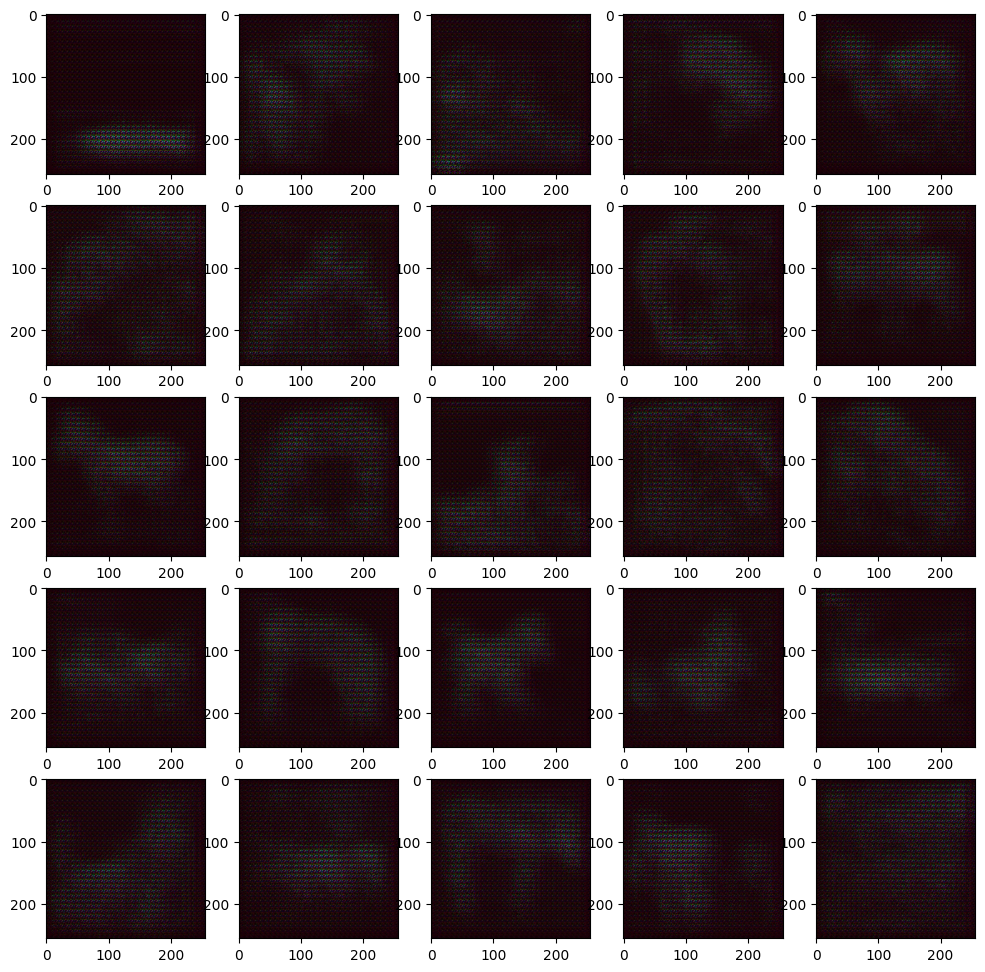

In [ ]:
for a_batch, b_batch in test_data:
    a_batch = a_batch.float().transpose(-1, -3)
    b_batch = b_batch.float().transpose(-1, -3)

    plt.figure(figsize=(12, 12))
    output = G_gen(F_gen(b_batch)).transpose(-1, 1).detach().cpu().numpy()
    for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.imshow(output[i]);
    break